In [431]:
import matplotlib.pyplot as plt
import datetime, time, math, cmocean, csv
import numpy as np
import netCDF4 as nc
from scipy import interpolate, stats
from matplotlib import rcParams
# from astropy.convolution import convolve, convolve_fft
from scipy import interpolate
from scipy.sparse import diags
import glob
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import pandas as pd
from matplotlib.dates import DateFormatter
# from astropy.convolution import convolve, convolve_fft

myFmt = DateFormatter('%m-%d')

### Functions 

In [4]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""
    from netCDF4 import Dataset

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()
    #print(out_vars.keys())
    return out_vars

In [445]:
def calc_profiles_solar(temps, secs, depths, depth_idx, time_idx, rho_0, sw_div, ktop=6, dz=0.02, bc_flx=False, its=5):

    """ salin in input variable is Salinity, S in output is storage 
    Modified for Raven to remove any k-rho relationships that are for ice/use salinity"""

    rho_1 = rho_0[depth_idx[0]]

    # poor programming! this should be an input variable!
    short_depth = depths[depth_idx[0]]

    # set up off/diagonal elements
    T_k = temps[time_idx,depth_idx[0]]
    T_k1 = temps[time_idx+1,depth_idx[0]]
    dt = secs[time_idx+1]-secs[time_idx] # just a scalar, same for whole column
    # sw_div = sw_div_i[time_idx,depth_idx[0]]

    # first attempt based on Lipscomb (1998)
    a = T_k1[:-1] - T_k1[1:]
    b = T_k1[2:] - T_k1[1:-1]
    dT = T_k1 - T_k

    # from Paterson 1994
    c_t = 152.5+7.122*T_k1

    bad_top_count = 0

    for i in range(its):

        if i==0:
            rho_n = rho_1[:-1]
        elif type(K)==bool:
            rho_n = rho_1[:-1]

        else:
            rho_n = np.array([rho_from_k(k, T_k1[vidx]) \
                            for vidx, k in np.ndenumerate(np.squeeze(K))],
                            dtype=np.float32)

        # HERE is where boundary condition needs to be changed!
        if bc_flx:
            dend = bc_flx*dz
        else:
            # was 2 for sea ice, now 0.3 for snow?
            dend = 0.3*(temps[time_idx+1,depth_idx[0][-1]+1]\
                    -temps[time_idx+1,depth_idx[0][-1]])

        K, d, A, det_0_num = iterate_solution_solar(dT, rho_n, c_t, dend, a, b, dt, sw_div)

        # work on this
        bad_snowtop = np.where((np.squeeze(K)>=.6)&(short_depth[:-1]>ktop)) #OG


        S = d/dz # this negates dz d is multiplied by to solve for k

    # save conduction and its divergence
    # print(np.shape(np.squeeze(K)[1:]), np.shape(T_k1[2:]), np.shape(T_k1[1:-1]))
    # print(A.shape, K.shape, a.shape, b.shape, T_k1.shape, rho_n.shape)
    # this is conserved
    if type(K)==bool:
        Fc_div = False
        Fc = False
    else:
        # print(np.shape(np.squeeze(K)), np.shape(T_k1))
        # print(np.shape(np.squeeze(K)[1:]), np.shape(np.squeeze(K)[0:-1]), np.shape(T_k1[2:]), np.shape(T_k1[:-2]))
        # Fc_div =  np.squeeze(K)[:-1]*(T_k1[2:]-T_k1[1:-1]) - (np.squeeze(K)[1:]*(T_k1[1:-1]-T_k1[:-2]))
        # Fc_div /= dz**2
        Fc_div = A.dot(K)/dz

        Fc = -np.squeeze(K)*a/dz
        # alt_div = np.squeeze(K)/dz
        # print(Fc)

    return K, rho_n, S, Fc_div, Fc, bad_top_count, det_0_num

In [447]:
def calc_profiles(temps, secs, depths, depth_idx, time_idx, rho_0, ktop=6, dz=0.02, bc_flx=False, dt=1, mask_dT=False, its=2):

    """ 
    Modified for Raven to remove any k-rho relationships that are for ice/use salinity
    
    bc_flx: lower boundary condition is flux instead of thermal conductivity"""

    rho_1 = rho_0[depth_idx[0]]

    short_depth = depths[depth_idx[0]]

    # set up off/diagonal elements
    T_k = temps[time_idx,depth_idx[0]]
    T_k1 = temps[time_idx+dt,depth_idx[0]]
    dt = secs[time_idx+dt]-secs[time_idx] # just a scalar, same for whole column


    # first attempt based on Lipscomb (1998)
    a = T_k1[:-1] - T_k1[1:]
    b = T_k1[2:] - T_k1[1:-1]
    dT = T_k1 - T_k
    # print('testing the assumption that dT=0!')
    if mask_dT:
        dT[np.where(np.abs(dT)<=0.0625)[0]] = 0

    ## masking dT<=|0.0625|
    # dT[np.where(np.abs(dT<=0.0625))[0]] = 0
    
    # from Paterson 1994
    c_t = 152.5+7.122*T_k1

    bad_top_count = 0

    ## was interated 5 times for sea ice, not sure why it's only 2 now
    ## no longer allowing the upper boundary to be lowered?
    for i in range(its):

        if i==0:
            rho_n = rho_1[:-1]
        elif type(K)==bool:
            rho_n = rho_1[:-1]
        else:
            rho_n = np.array([rho_from_k(k, T_k1[vidx]) \
                            for vidx, k in np.ndenumerate(np.squeeze(K))],
                            dtype=np.float32)

        # HERE is where boundary condition needs to be changed!
        if bc_flx:
            dend = bc_flx*dz
        else:
            # was 2 for sea ice, now 0.3 for snow?
            dend = 0.3*(temps[time_idx+1,depth_idx[0][-1]+1]\
                    -temps[time_idx+1,depth_idx[0][-1]])

        K, d, A, det_0_num = iterate_solution(dT, rho_n, c_t, dend, a, b, dt)

        # work on this
        # bad_snowtop = np.where((np.squeeze(K)>=.6)&(short_depth[:-1]>ktop)) #OG

        S = d/dz # this negates dz d is multiplied by to solve for k

    # save conduction and its divergence
    # print(np.shape(np.squeeze(K)[1:]), np.shape(T_k1[2:]), np.shape(T_k1[1:-1]))
    # print(A.shape, K.shape, a.shape, b.shape, T_k1.shape, rho_n.shape)
    # this is conserved
    if type(K)==bool:
        Fc_div = False
        Fc = False
    else:
        # print(np.shape(np.squeeze(K)), np.shape(T_k1))
        # print(np.shape(np.squeeze(K)[1:]), np.shape(np.squeeze(K)[0:-1]), np.shape(T_k1[2:]), np.shape(T_k1[:-2]))
        # Fc_div =  np.squeeze(K)[:-1]*(T_k1[2:]-T_k1[1:-1]) - (np.squeeze(K)[1:]*(T_k1[1:-1]-T_k1[:-2]))
        # Fc_div /= dz**2
        Fc_div = A.dot(K)/dz

        Fc = -np.squeeze(K)*a/dz
        # alt_div = np.squeeze(K)/dz
        # print(Fc)

    return K, rho_n, S, Fc_div, Fc, bad_top_count, det_0_num

In [444]:
def iterate_solution_solar(dT_i, rho_i, c_i, d_last, a_i, b_i, dt_i, sw_div_i, dz_i=0.02):

    # separating the calculation of d in a separate function might make it more readable

    d = dT_i[:-1]*c_i[:-1]*rho_i*dz_i**2/dt_i # Lipscomb

    # with solar, added 4/17/25
    d_S = dT_i[:-1]*c_i[:-1]*rho_i*dz_i**2/dt_i - sw_div_i[:-1]*dz_i# Lipscomb
    
    # need some sort of boundary condition
    d_S[-1] -= d_last

    offset = [0,1]
    A = diags([a_i,b_i],offset).toarray()

    # turn into matrix with correct orientation
    d_S = np.array([d_S], dtype=np.float64).T

    # if np.linalg.det(A)!=0:
    #     K_i = np.linalg.inv(A).dot(d)
    # else:
    #     K_i = np.linalg.pinv(A).dot(d)
    #
    #     # K_i = False
    K_i = np.linalg.pinv(A).dot(d_S)


    if np.linalg.det(A)==0:
        det_0 = 1
    else:
        det_0 = 0


    return K_i, d, A, det_0

In [443]:
def iterate_solution(dT_i, rho_i, c_i, d_last, a_i, b_i, dt_i, dz_i=0.02):

    # separating the calculation of d in a separate function might make it more readable

    d = dT_i[:-1]*c_i[:-1]*rho_i*dz_i**2/dt_i # Lipscomb

    # with solar, added 4/17/25
    d_S = dT_i[:-1]*c_i[:-1]*rho_i*dz_i**2/dt_i #- sw_div_i[:-1]*dz_i# Lipscomb
    
    # need some sort of boundary condition
    d_S[-1] -= d_last

    offset = [0,1]
    A = diags([a_i,b_i],offset).toarray()

    # turn into matrix with correct orientation
    d_S = np.array([d_S], dtype=np.float64).T

    # if np.linalg.det(A)!=0:
    #     K_i = np.linalg.inv(A).dot(d)
    # else:
    #     K_i = np.linalg.pinv(A).dot(d)
    #
    #     # K_i = False
    K_i = np.linalg.pinv(A).dot(d_S)


    if np.linalg.det(A)==0:
        det_0 = 1
    else:
        det_0 = 0


    return K_i, d, A, det_0

In [14]:
def rho_from_k(k, T):

    rhos, ks = calc_k_approx(T)
    #print('in rho_from_k ks, rhos, k shapes:', np.shape(ks), np.shape(rhos), np.shape(k))

    rhos = np.squeeze(rhos)
    ks = np.squeeze(ks)
    # print(ks, k)

    f = interpolate.interp1d(ks, rhos)

    if k>ks.max():
        k = ks.max()
    elif k<ks.min():
        k = ks.min()

    rho_out = f(k)

    return rho_out

In [15]:
def calc_k_approx(T, rho_vals=np.linspace(50,1000,96)):

    """ calculate k values based on eq5 from calonne 2019
        T is in Kelvin"""

    rhos = []
    ks = []

    # constants for calculation
    a = 0.02 # m3/kg
    k_ref_i = 2.107 # W/m/K
    k_ref_a = 0.024 # W/m/K

    # # just use simple values for now, will want them to be functions of T later
    # # current values for T=-3C
    k_i = 9.828*np.exp(-5.7*10.**(-3)*T)
    k_a = 0.024 # get the rest of the linear approx of T

    for rho in rho_vals:

        theta = 1./(1.+np.exp(-2.*a*(rho-450.)))
        k_ref_firn = 2.107 + 0.003618*(rho-917.)
        k_ref_snow = 0.024 - (1.23*10**(-4))*rho + (2.5*10**(-6))*(rho**2)

        x_f = (1. - theta)*(k_i*k_a/(k_ref_i*k_ref_a))*k_ref_snow \
                + theta*(k_i/k_ref_i)*k_ref_firn

        # print(x_f)
        ks.append(np.float32(x_f))#[0])
        rhos.append(np.float32(rho))

    return rhos, ks

In [16]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [116]:
def calc_sw_ext(sw_sfc, kappa, depths_in, f_nir=0.5):
    """ swc_sfc is net SW from the atmosphere (SWD-SWU) 
    kappa is snow extinction coefficient, which is going to be used as a tuning parameter
    f_nir is the fraction of SW that is assumed to be NIR (as opposed to visible)
    depths is assumed to be centimeters below the surface with intervals of 2cm, i.e., 2, 4, 6 etc 
    should depths start at 0 or 2? """

    ## so that absorbed SW, clacluated as the difference between levels, covers the temperature
    # depths_in += .01

    ## transmitted SW at each level
    sw_t = f_nir*sw_sfc*np.ma.exp(-kappa*np.abs(depths_in))

    ## absorbed SW at each level
    # indexing will need to change to use SWN timeseries
    sw_a_lower = sw_t[:,:-1] - sw_t[:,1:]


    ## I think this will only work if depths_in is negative downwards
    print(np.where(depths_in==2))
    sfc_sw_a = sw_sfc[np.where(depths_in==0)]-sw_t[np.where(depths_in==-2.)]
    
    sw_a = np.ma.copy(sw_a_lower)
    sw_a[np.where(depths_in==0)] = sfc_sw_a
    
    # sw_a = np.ma.concatenate((sfc_sw_a[:, np.newaxis], sw_a), axis=1) ## this is wrong because of 2D array with values above surface
    # sw_a = np.ma.masked_array(sw_a, mask=sw_t.mask)
    
    return sw_a, sw_t

In [278]:
def calc_sw_abs_single(sw_sfc, kappa, depths_in, f_nir=0.5):
    """ for profile of sw absorbed/extinction at one time step!
    swc_sfc is net SW from the atmosphere (SWD-SWU) 
    kappa is snow extinction coefficient, which is going to be used as a tuning parameter
    f_nir is the fraction of SW that is assumed to be NIR (as opposed to visible)
    depths is assumed to be centimeters below the surface with intervals of 2cm, i.e., 2, 4, 6 etc 
    should depths start at 0 or 2? """

    ## so that absorbed SW, clacluated as the difference between levels, covers the temperature
    # depths_in += .01

    ## transmitted SW at each level
    sw_t = f_nir*sw_sfc*np.ma.exp(-kappa*np.abs(depths_in))

    ## absorbed SW at each level
    # indexing will need to change to use SWN timeseries
    sw_a_lower = sw_t[:-1] - sw_t[1:]


    ## I think this will only work if depths_in is negative downwards
    sfc_sw_a = [sw_sfc-sw_t[0]]
    
    # sw_a = np.ma.copy(sw_a_lower)
    # sw_a[np.where(depths_in==0)] = sfc_sw_a
    
    sw_a = np.ma.concatenate((sfc_sw_a, sw_a_lower), axis=0) ## this is wrong because of 2D array with values above surface
    # sw_a = np.ma.masked_array(sw_a, mask=sw_t.mask)
    
    return sw_a, sw_t

### Load data

In [406]:


simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
# fn = 'firnprofile_maxheight_solar-correction_created_20250417.nc'
fn = 'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data = {}
if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    varnames = ['temperature','initial_height','time']
    fdic = load_netcdf(simba_filepath+fn, varnames)
else:
    varnames = ['temp','initial_height','time']
    fdic = load_netcdf(fn, varnames)

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])
else:    
    fdic['dates'] = np.asarray([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(s)) for s in fdic['time']])
season_data['seconds'] = fdic['time']

for var in ['temp','dates','initial_height']:
    if var=='temp' and fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
        season_data['temp'] = fdic['temperature']
    else:
        season_data[var] = fdic[var]

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    season_data['initial_height'] = season_data['initial_height'][::-1]

In [407]:
simba_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in season_data['dates']])

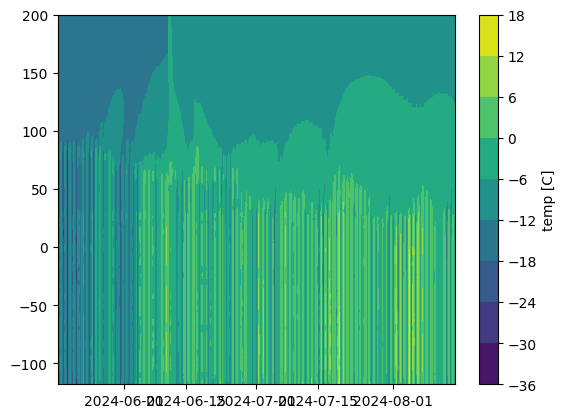

In [408]:
cb = plt.contourf(season_data['dates'], season_data['initial_height'], np.swapaxes(season_data['temp'],0,1,))
plt.colorbar(cb, label='temp [C]')
plt.show()

In [409]:
df = pd.read_csv('Raven2024_SIMBA_sfc_id_combined-corrected-maxheight_raw-despiked-72h-05threshold_20250416.csv')


simba_sfc_dates = np.array([datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])       
simba_sfc_in = df['max_index'].values
simba_sfc_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in simba_sfc_dates])



In [410]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')

# asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/full_period/'
# asfs_lev2_files = glob.glob(asfs_filepath+'sleighsfsseb.sleighsfs.level2.0.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['up_short_hemisp_qc','up_long_hemisp_qc','down_short_hemisp_qc','down_long_hemisp_qc','subsurface_heat_flux_A_qc',
                  'subsurface_heat_flux_B_qc','skin_temp_surface_qc','temp_qc','snow_depth_qc','zenith_true_qc',
                  'down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp',
                  'snow_depth','temp','brightness_temp_surface','skin_temp_surface','subsurface_heat_flux_A','subsurface_heat_flux_B',
                  'subsurface_heat_flux_C','zenith_true','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )
asfs_data_lev2['net_short_hemisp'] = asfs_data_lev2['down_short_hemisp'] - asfs_data_lev2['up_short_hemisp']
asfs_data_lev2['albedo'] =  asfs_data_lev2['up_short_hemisp']/asfs_data_lev2['down_short_hemisp']

sleigh_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in asfs_data_lev2['dates']])


with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_all-times_20250113.npz') as npz:
    asfs_data_lev2['skin_temp'] = np.ma.MaskedArray(**npz)

/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

In [411]:
sleigh_swn = asfs_data_lev2['net_short_hemisp']
sleigh_dates = asfs_data_lev2['dates']
sleigh_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in sleigh_dates])


#### get varaibles to same time steps: 
interpolate SW and surface to corrected simba temp time steps

In [412]:
f_simba_sfc = interpolate.interp1d(simba_sfc_seconds, simba_sfc_in, fill_value=-999, bounds_error=False)

simba_sfc = f_simba_sfc(simba_seconds)
simba_sfc = np.ma.masked_equal(simba_sfc, -999)

In [413]:
f_swn = interpolate.interp1d(sleigh_seconds, sleigh_swn, fill_value=-999, bounds_error=False)

swn = f_swn(simba_seconds)
swn = np.ma.masked_equal(swn, -999)

f_fp_a = interpolate.interp1d(sleigh_seconds, asfs_data_lev2['subsurface_heat_flux_A'], fill_value=-999, bounds_error=False)
fp_a = f_fp_a(simba_seconds)
fp_a = np.ma.masked_less(fp_a, -100)

f_fp_b = interpolate.interp1d(sleigh_seconds, asfs_data_lev2['subsurface_heat_flux_B'], fill_value=-999, bounds_error=False)
fp_b = f_fp_b(simba_seconds)
fp_b = np.ma.masked_less(fp_b, -100)

f_fp_c = interpolate.interp1d(sleigh_seconds, asfs_data_lev2['subsurface_heat_flux_C'], fill_value=-999, bounds_error=False)
fp_c = f_fp_b(simba_seconds)
fp_c = np.ma.masked_less(fp_c, -100)

In [377]:
print(simba_seconds)

[1.7159040e+09 1.7159049e+09 1.7159058e+09 ... 1.7236773e+09 1.7236782e+09
 1.7236791e+09]


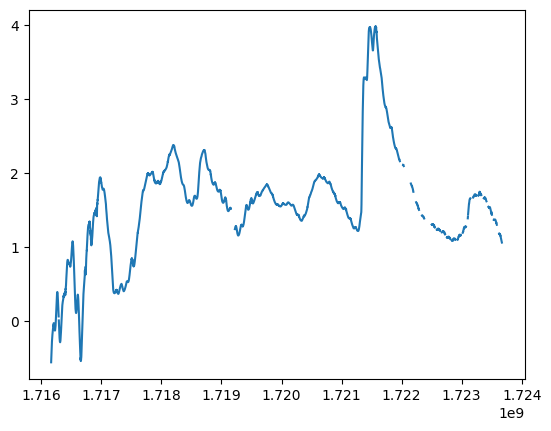

In [379]:
plt.plot(simba_seconds, fp_c)

### Need to set up SW extinction

In [357]:
print(swn.shape, simba_sfc.shape, season_data['temp'].shape)

(8640,) (8640,) (8640, 160)


In [414]:
simba_depths = season_data['initial_height']

In [415]:
print(season_data['dates'])

[datetime.datetime(2024, 5, 17, 0, 0)
 datetime.datetime(2024, 5, 17, 0, 15)
 datetime.datetime(2024, 5, 17, 0, 30) ...
 datetime.datetime(2024, 8, 14, 23, 15)
 datetime.datetime(2024, 8, 14, 23, 30)
 datetime.datetime(2024, 8, 14, 23, 45)]


Just trying to get retrieval working before adding solar...

In [416]:
## for plotting and comparing
dTdt = (temp_kelv[1:,:] - temp_kelv[:-1,:])#/(15.*60) # timesteps are 15 minutes
dTdz = (temp_kelv[:,1:] - temp_kelv[:,:-1])#/0.02 # vertical resolution is 2 cm

In [417]:
temp_kelv = season_data['temp']+273.15
imb_depth = season_data['initial_height']
imb_depth_m = imb_depth/100.

# how best to limit depths?
# sfc_height = -350/100. # from thermistor locations at install
# bottom_height = -(360+75)/100. # currently lowest level is now bottom flx plate; was set to -470 right now removing bottom thermistor that looks like it might be the air temp?

bottom_height = -76./100. ## bottom flux plate was installed -75 cm below surface? and now depth variable is referenced to initial height?

imb_secs = np.array([(t-datetime.datetime(1970,1,1)).total_seconds() for _,t in np.ndenumerate(season_data['dates'])])

In [418]:
sw_zeros = np.zeros(temp_kelv.shape)

In [419]:
from scipy.ndimage import uniform_filter1d

def rolling_mean_along_axis(a, W, axis=-1):
    # a : Input ndarray
    # W : Window size
    # axis : Axis along which we will apply rolling/sliding mean
    hW = W//2
    L = a.shape[axis]-W+1   
    indexer = [slice(None) for _ in range(a.ndim)]
    indexer[axis] = slice(hW,hW+L)
    return uniform_filter1d(a,W,axis=axis)[tuple(indexer)]

In [420]:
temp_kelv_smoothed = rolling_mean_along_axis(temp_kelv, 3, axis=1)

dTdt_smoothed = (temp_kelv_smoothed[1:,:] - temp_kelv_smoothed[:-1,:])#/(15.*60) # timesteps are 15 minutes
dTdz_smoothed = (temp_kelv_smoothed[:,1:] - temp_kelv_smoothed[:,:-1])#/0.02 # vertical resolution is 2 cm

In [421]:
st_date = datetime.datetime(2024,6,1)
en_date = datetime.datetime(2024,6,2)
date_idx_imb = np.where((season_data['dates']>st_date)&(season_data['dates']<en_date) )[0]

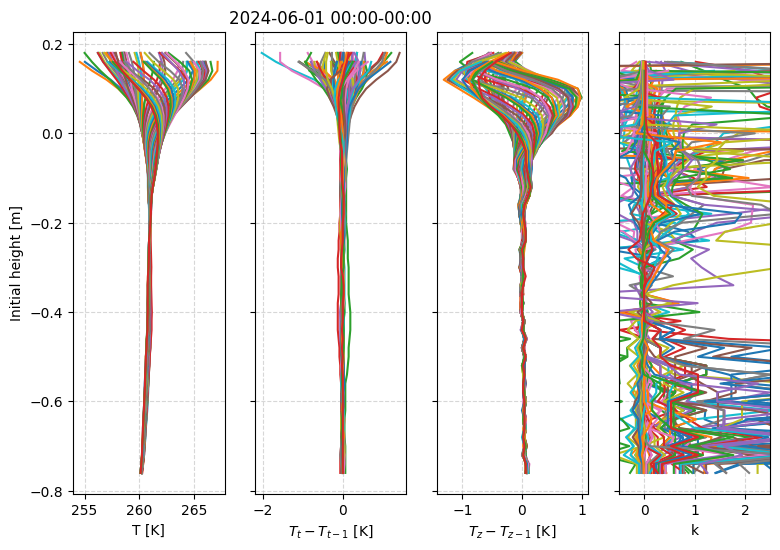

In [387]:


## rename these!
k_2d = []
rho_2d = []
S_2d = []
Fc_2d = []
Fc_div_2d = []

plt_times = []
plt_secs = []
plt_bad_timesteps = []

fig, axs = plt.subplots(1,4, figsize=(9,6), sharey=True)
axs[0].set_ylabel('Initial height [m]')

for _, t_idx in np.ndenumerate(date_idx_imb[1:]):
    
        all_depths_K = []
        all_depths_rho = []
        all_depths_S = []
        all_depths_Fc = []
        all_depths_Fc_div = []

        depth_idx = np.where((imb_depth_m<(simba_sfc[t_idx])/100.)&(imb_depth_m>=bottom_height))
        # depth_idx = np.where((imb_depth_m<(simba_sfc[t_idx]-40.)/100.)&(imb_depth_m>=bottom_height))
        rho = np.full(imb_depth_m.shape, 300.)
        sw_abs, _ = calc_sw_abs_single(swn[t_idx], 15., imb_depth_m[depth_idx])
        sw_abs *= 0.
        
        K, rho_n, S, Fc_div, Fc, bad_top, det_0_num = calc_profiles(temp_kelv_smoothed[:,:],
                                    imb_secs[:], imb_depth_m, depth_idx, t_idx, rho, sw_abs, 
                                    bc_flx=-fp_a[t_idx], its=2) # bc_flx = 'boundary condition flux'

        axs[0].plot(np.squeeze(temp_kelv_smoothed[t_idx, depth_idx]), imb_depth_m[depth_idx], label=t_idx)#'t=0')
    
        axs[1].plot(np.squeeze(dTdt_smoothed[t_idx, depth_idx]), imb_depth_m[depth_idx])
        axs[2].plot(np.squeeze(dTdz_smoothed[t_idx, depth_idx]), imb_depth_m[depth_idx])
        axs[3].plot(K, imb_depth_m[depth_idx][:-1])

    
        # print(K.shape, imb_depth_m[depth_idx].shape, temp_kelv[:,depth_idx].shape)
        if type(K)!=bool:
            # print(sd, len(K), len(depth_idx[0]))
            all_depths_K.append(np.squeeze(K))
            all_depths_rho.append(rho_n)
            all_depths_S.append(np.squeeze(S)[:-1])
            all_depths_Fc.append(Fc)
            all_depths_Fc_div.append(Fc_div)


            len_ld = len(depth_idx[0])

# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[0], depth_idx]), imb_depth_m[depth_idx], label='t=-1')
# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[2], depth_idx]), imb_depth_m[depth_idx], label='t=+1')
# axs[0].legend(loc='best')
#for ax, label in zip(axs.ravel(), ['Temp [K]', 'dT/dt', 'dT/dz','k']):
for ax, label in zip(axs.ravel(), ['T [K]', '$T_t-T_{t-1}$ [K]', '$T_z-T_{z-1}$ [K]','k']):
    ax.set_xlabel(label)
    ax.grid(alpha=.5, ls='--')

axs[-1].set_xlim(-.5,2.5)
axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'-'+en_date.strftime('%H:%M'))
#plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d:%H:%M')+'-'+en_date.strftime('%H:%M')+'.png', dpi=200)
plt.show()

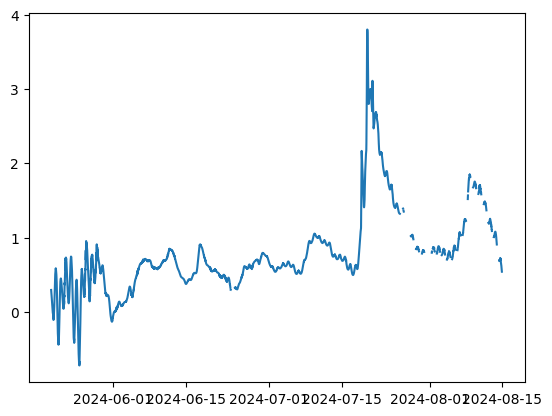

In [388]:
plt.plot(season_data['dates'], fp_a)
plt.show()

In [428]:
kernel_avg_10 = [1./(3)]*(3)

smoothed_temp = []
for t in range(temp_kelv.shape[0]):

    T_kern = np.squeeze(np.copy(temp_kelv[t,:]))
    T_smoothed = convolve(T_kern, kernel_avg_10, boundary='extend')
    T_kern = T_smoothed

    smoothed_temp.append(T_kern)

smoothed_temp = np.asarray(smoothed_temp)

## for plotting and comparing
smoothed_dTdt = (smoothed_temp[1:,:] - smoothed_temp[:-1,:])#/(15.*60) # timesteps are 15 minutes
smoothed_dTdz = (smoothed_temp[:,1:] - smoothed_temp[:,:-1])#/0.02 # vertical resolution is 2 cm


NameError: name 'convolve' is not defined

In [448]:
st_date = datetime.datetime(2024,6,1)
en_date = datetime.datetime(2024,6,15)
date_idx_imb = np.where((season_data['dates']>st_date)&(season_data['dates']<en_date) )[0]

## rename these!
k_2d = []
rho_2d = []
S_2d = []
Fc_2d = []
plt_times = []


for _, t_idx in np.ndenumerate(date_idx_imb[1:]):
    # print(t_idx)
    # if swn[t_idx]>5:
    #     continue

    top_level = simba_sfc[t_idx]#-40.
    depth_idx = np.where((imb_depth_m<(top_level/100.))&(imb_depth_m>=bottom_height))
    rho = np.full(imb_depth_m.shape, 300.)

    ## should use linear change of kappa from SW correction!
    sw_abs, _ = calc_sw_abs_single(swn[t_idx], 15., imb_depth_m[depth_idx])
    sw_abs *= 0.

    # try:
    K, rho_n, S, Fc_div, Fc, bad_top, det_0_num = calc_profiles(temp_kelv[:,:],
                                imb_secs[:], imb_depth_m, depth_idx, t_idx, rho, sw_abs,
                                bc_flx=-fp_b[t_idx], its=2) # bc_flx = 'boundary condition flux'
    # NEED TO CHECK SIGN OF FLUX PLATE CONDUCTION!!!

    pad_top = np.full( int((imb_depth[0]-top_level)/2+1) ,-999)
    pad_bottom = np.full(int((bottom_height*100.-imb_depth[-1])/2+1),-999)

    if type(K)!=bool:
        k_2d.append( np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(K), pad_bottom),axis=0)), axis=0) )
        rho_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (rho_n, pad_bottom),axis=0)),axis=0) )
        S_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(S)[:-1], pad_bottom),axis=0)),axis=0) )
        Fc_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (Fc, pad_bottom),axis=0)),axis=0) )
        # all_depths_Fc_div.append(Fc_div)
        plt_times.append(season_data['dates'][t_idx])
        
        len_ld = len(depth_idx[0])
    # except:
    #     try_bool = False
        
plt_times = np.array(plt_times)
keff = np.ma.masked_equal(k_2d, -999)
density = np.ma.masked_equal(rho_2d, -999)

FC = np.ma.masked_equal(Fc_2d, -999)
storage = np.ma.masked_equal(S_2d, -999)

In [449]:
print(keff.shape)

(1342, 160)


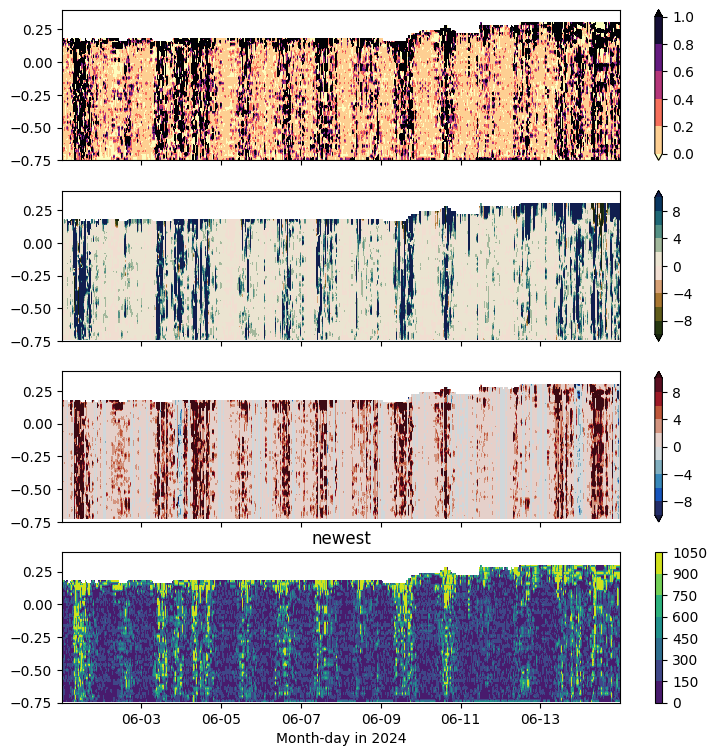

In [450]:
fig, axs = plt.subplots(4, figsize=(9,9), sharey=True, sharex=True)
cb = axs[0].contourf(plt_times, imb_depth_m, np.swapaxes(keff,0,1), cmap=plt.cm.magma_r, levels=np.arange(0,1.01,.2), extend='both')
plt.ylim(-0.75,.4)
plt.colorbar(cb,ax=axs[0])

cb = axs[1].contourf(plt_times, imb_depth_m, np.swapaxes(FC,0,1), levels=np.linspace(-10,10,11), extend='both', cmap=cmocean.cm.tarn)
plt.colorbar(cb,ax=axs[1])

cb = axs[2].contourf(plt_times, imb_depth_m[:-1], np.swapaxes(storage,0,1), levels=np.linspace(-10,10,11), extend='both', cmap=cmocean.cm.balance)
plt.colorbar(cb,ax=axs[2])

cb = axs[3].contourf(plt_times, imb_depth_m, np.swapaxes(density,0,1))#, levels=np.linspace(-10,10,11), extend='both', cmap=cmocean.cm.balance)
plt.colorbar(cb,ax=axs[3])

axs[-1].xaxis.set_major_formatter(myFmt)
axs[-1].set_xlabel('Month-day in 2024')
plt.title('newest')
plt.show()

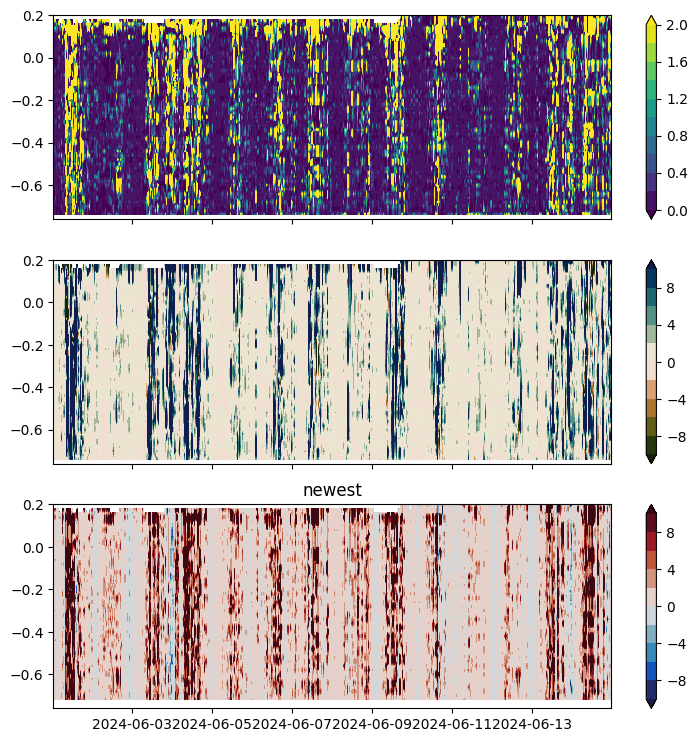

In [451]:
fig, axs = plt.subplots(3, figsize=(9,9), sharey=True, sharex=True)
cb = axs[0].contourf(plt_times, imb_depth_m, np.swapaxes(keff,0,1), levels=np.linspace(0,2,11), extend='both')
plt.ylim(-0.76,0.2)
plt.colorbar(cb,ax=axs[0])

cb = axs[1].contourf(plt_times, imb_depth_m, np.swapaxes(FC,0,1), levels=np.linspace(-10,10,11), extend='both', cmap=cmocean.cm.tarn)
plt.colorbar(cb,ax=axs[1])

cb = axs[2].contourf(plt_times, imb_depth_m[:-1], np.swapaxes(storage,0,1), levels=np.linspace(-10,10,11), extend='both', cmap=cmocean.cm.balance)
plt.colorbar(cb,ax=axs[2])

ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
plt.title('newest')
plt.show()

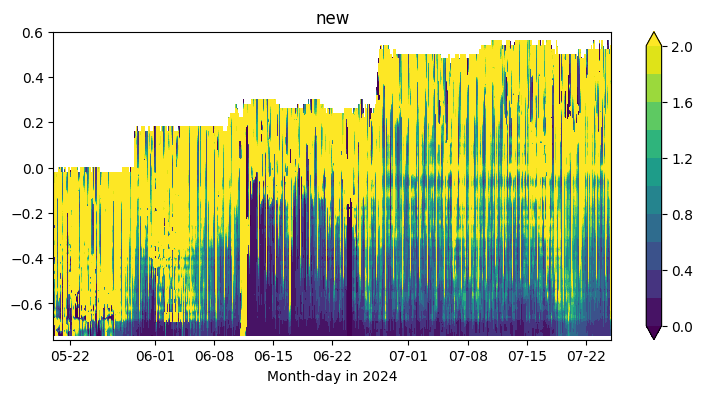

In [243]:
fig, ax = plt.subplots(1, figsize=(9,4))
cb = plt.contourf(plt_times, imb_depth_m, np.swapaxes(keff,0,1), levels=np.linspace(0,2,11), extend='both')
plt.ylim(-0.76,0.6)
plt.colorbar(cb,)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
plt.title('new')
plt.show()

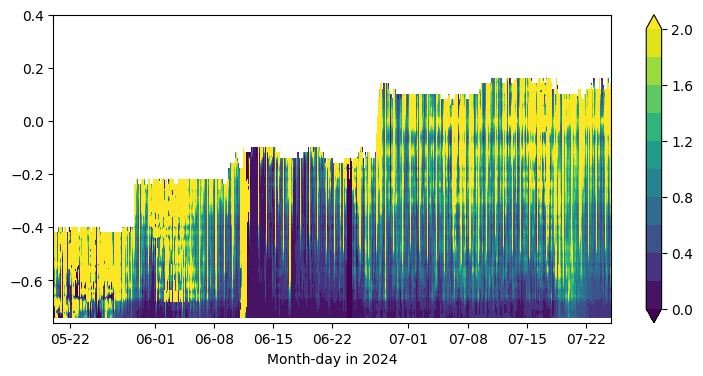

In [239]:
fig, ax = plt.subplots(1, figsize=(9,4))
cb = plt.contourf(plt_times, imb_depth_m, np.swapaxes(keff,0,1), levels=np.linspace(0,2,11), extend='both')
plt.ylim(-0.76,0.4)
plt.colorbar(cb,)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
plt.show()